In [116]:
import numpy as np
import matplotlib.pyplot as plt
import epidemic_model_classes_numba as epi_mod
from data_loading import LoadData 
from proj_consts import ProjectConsts
import pandas as pd
from PIL import Image
import time
import os

log_paths = ["../logs/sdumont/log2021-05-19_20-23-56/", "../logs/sdumont/log2021-05-19_20-02-34/"]
log_labels = ["Fixed window", "Adaptive window"]

# data_path = open("data_path.txt", "r").read()
# df_brazil_state_cases = pd.read_csv(data_path)

# pop_state_dat = open(f"{ProjectConsts.DATA_PATH}/pop_states.csv", "r").read().split("\n")
# pop_state = {}
# for i in range(len(pop_state_dat)-1):
#     pop_state_dat[i] = pop_state_dat[i].split(", ")
#     pop_state[pop_state_dat[i][0]] = int(pop_state_dat[i][1])

In [117]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD']


In [118]:
# data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])

In [119]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1

n_post = 3
print(n_post)

3


In [120]:
location = locations[0].split(" ")[0]

days_sets = sorted(os.listdir(log_paths[0]+"Posterior1/%s/%s/"%(location, models[0])), key=lambda x: int(x.split("_")[0]))[:-1]
n_days = len(days_sets)

days = []

for days_set in days_sets:
    
    days.append(int(days_set.split("_")[0]))

days = np.array(days)

In [121]:
days = days[days <= 345]
days_sets = days_sets[:len(days)]
n_days = len(days_sets)

In [122]:
rmsd_train = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_val= [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_total = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]

trials = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(log_paths)):
        
        params.append(np.zeros((n_days, model.nparams)))
        
        path = log_paths[i]+"Posterior%i/%s/%s/" % (n_post, location, models[model_idx])

        for days_idx in range(len(days_sets)):

            params[-1][days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")

            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]

            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line

                if ("Number of trials" in log_file[line]):

                    trials[i][model_idx, days_idx] = int(log_file[line].split(" ")[-1])

            rmsd_train[i][model_idx, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[i][model_idx, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[i][model_idx, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

In [123]:
rmsd_train[0]

array([[0.142478, 0.105958, 0.092655, 0.040734, 0.045551, 0.056863,
        0.043818, 0.048151, 0.030134, 0.024129, 0.019122, 0.01977 ,
        0.018338, 0.031785, 0.024381, 0.027858, 0.022724, 0.018474,
        0.022252, 0.018877, 0.020275, 0.014308, 0.015606, 0.017246,
        0.01431 , 0.017559, 0.013349, 0.016493, 0.015942, 0.019398,
        0.022445, 0.022378, 0.02117 , 0.021099, 0.020436, 0.01837 ,
        0.019904, 0.022632, 0.02182 , 0.020241, 0.019595, 0.018705,
        0.015081, 0.014858, 0.019248, 0.026139, 0.018187, 0.01932 ,
        0.022562, 0.0232  , 0.022481, 0.020556, 0.016406, 0.015396,
        0.018621, 0.022998, 0.029357, 0.033074, 0.030843, 0.027266,
        0.018919, 0.014311, 0.021284, 0.014962, 0.017548, 0.012669]])

In [124]:
plt.rcParams.update({'font.size': 22})

def best_rows_cols(n):
    
    rows = 1
    cols = 1
    
    while (rows*cols < n):
        
        if (rows == cols):
            
            cols += 1
            
        else:
            
            rows += 1
            
    return np.array([rows, cols])

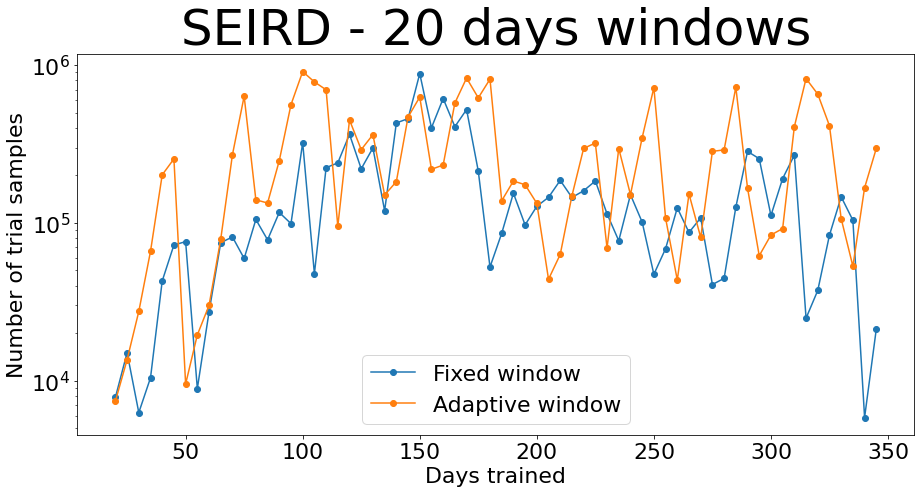

In [125]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,7))
        
    for j in range(len(trials)):
            
        plt.plot(days, trials[j][model_idx], "-o", label=log_labels[j])
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel("Number of trial samples")
        plt.yscale("log")
        plt.title(model.plot_name+" - 20 days windows", fontsize=50)
            
    plt.show()

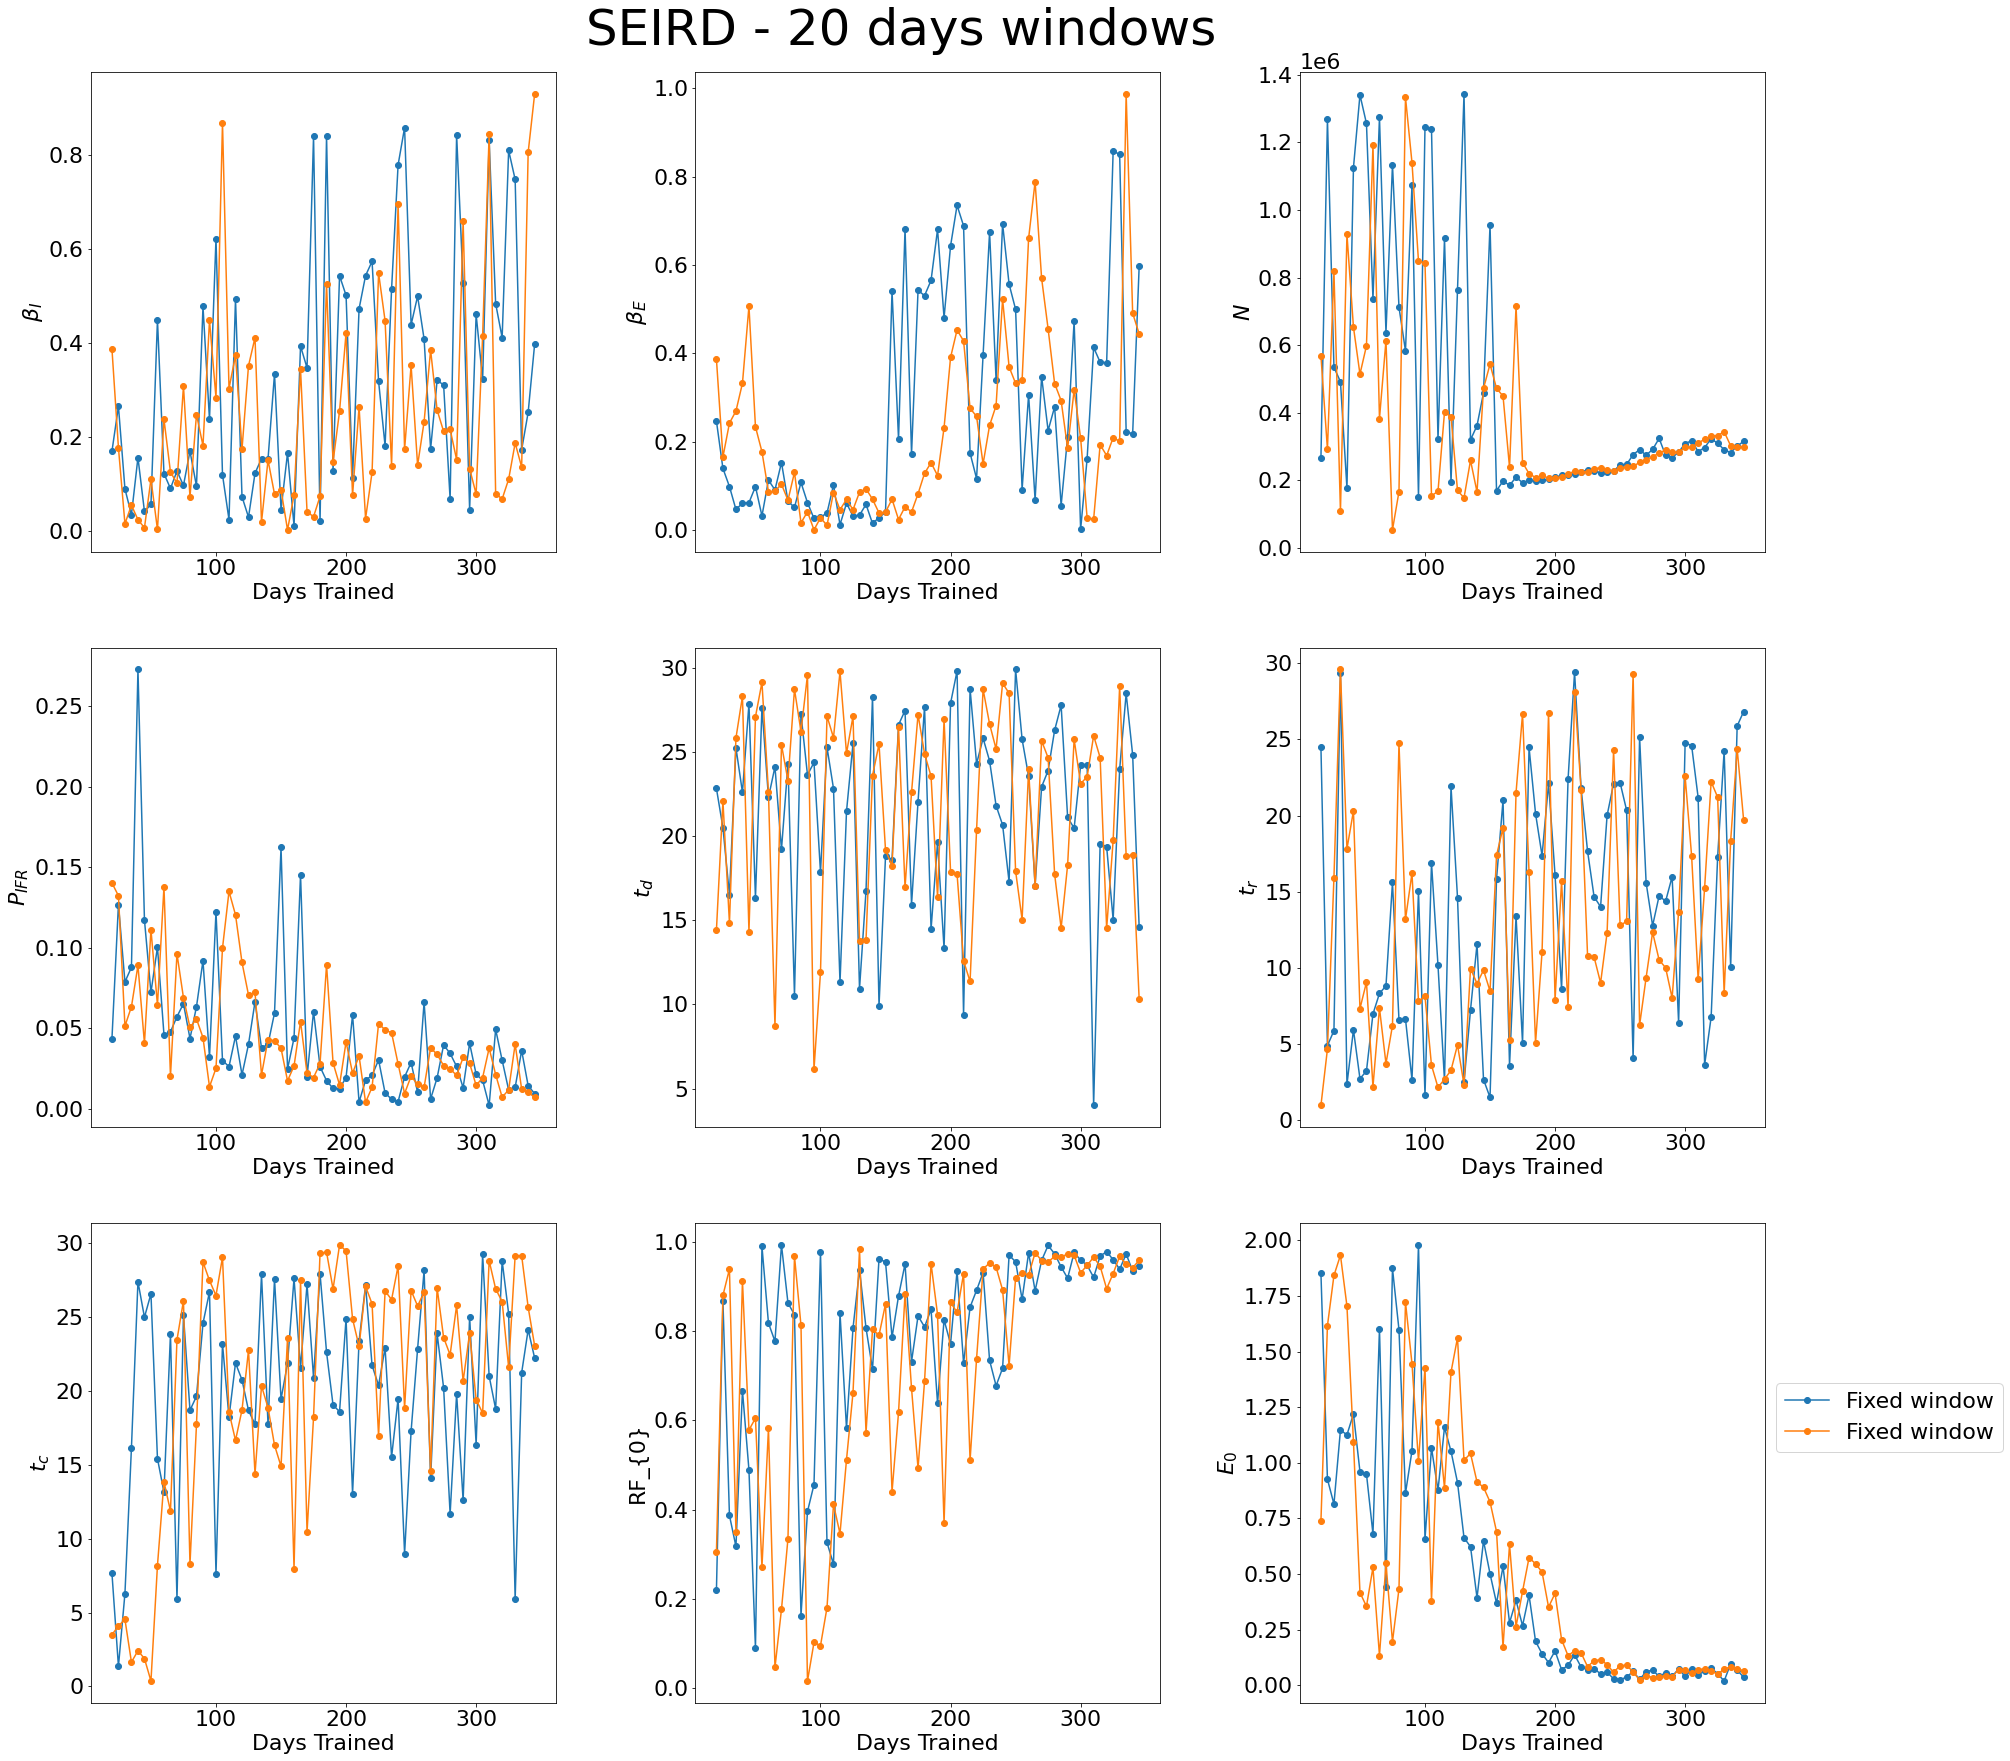

In [126]:
for j in range(len(models)):
    
    model = getattr(epi_mod, models[j])
    
    plt.figure(figsize=(10*best_rows_cols(params[0].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)

    for i in range(params[0].shape[-1]):

        plt.subplot(*best_rows_cols(params[0].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
#         for j in range(params[p].shape[0]):
        for p in range(len(params)):
            plt.plot(days, params[p][:,i], "-o", label=log_labels[j])
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):

            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")

    plt.suptitle(model.plot_name+" - 20 days windows", fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

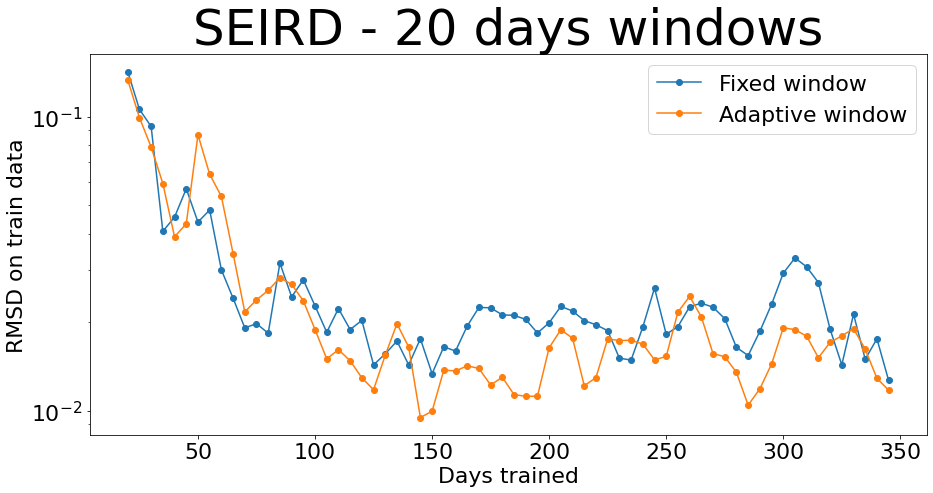

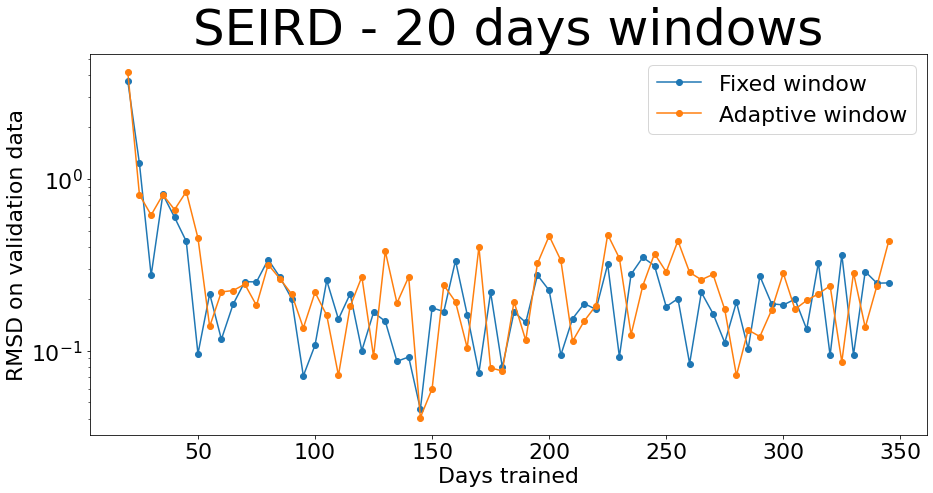

In [127]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)-1):
        
        plt.figure(figsize=(15,7))
        
        for j in range(len(rmsd[i])):
            
            plt.plot(days, rmsd[i][j][model_idx], "-o", label=log_labels[j])
            plt.legend()
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.yscale("log")
            plt.title(model.plot_name+" - 20 days windows", fontsize=50)
            
    plt.show()

In [128]:
len(np.where(rmsd[0][1] < rmsd[0][0])[0])/len(rmsd[1][1].T)*100

74.24242424242425

In [129]:
len(np.where(rmsd[1][1] < rmsd[1][0])[0])/len(rmsd[1][1].T)*100

45.45454545454545

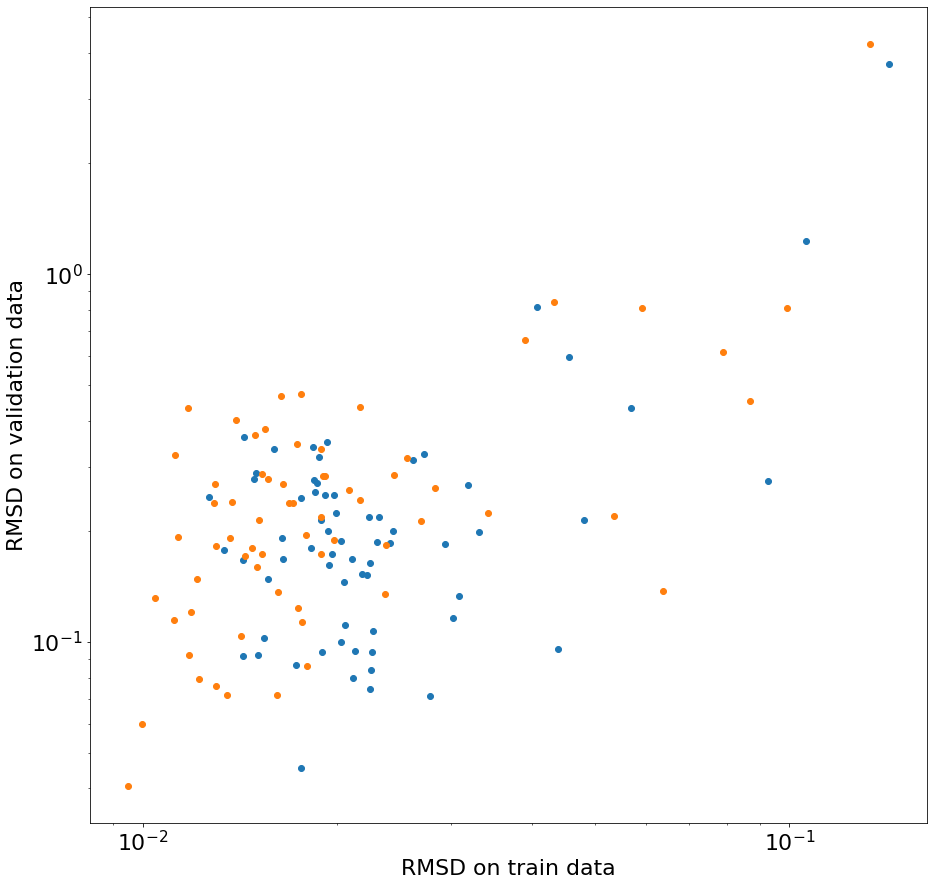

In [130]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,15))
    
    xx = np.linspace(min(np.min(rmsd[0]), np.min(rmsd[1])), min(np.min(rmsd[0]), np.min(rmsd[1])), 2)
    
    for j in range(len(rmsd[0])):
        
        plt.plot(rmsd[0][j].flatten(), rmsd[1][j].flatten(), "o", label="Posterior %i"%(j+1))
#         plt.legend()
        plt.xlabel(rmsd_names[0])
        plt.ylabel(rmsd_names[1])
        plt.xscale("log")
        plt.yscale("log")
#         plt.title(model.plot_name, fontsize=50)
    plt.show()

In [131]:
from scipy.stats import pearsonr

for j in range(len(log_paths)):
    print("--- ", log_labels[j], " ---")
    print("RMSD on train and validation Pearson Correlations:")
    print("Posterior %i:"%(i+1), pearsonr(rmsd[0][j].flatten(), rmsd[1][j].flatten()))
    print()

---  Fixed window  ---
RMSD on train and validation Pearson Correlations:
Posterior 2: (0.7999207732455818, 7.889492736526852e-16)

---  Adaptive window  ---
RMSD on train and validation Pearson Correlations:
Posterior 2: (0.7341425422557488, 2.319461753739971e-12)

